# Deep Bidirectional GRU Model with an embedding layer to learn embeddings

In [36]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load data
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

In [3]:
# Map sentiments to 3 classes
label_map = {
    "Mild_Pos": "positive", "Strong_Pos": "positive",
    "Mild_Neg": "negative", "Strong_Neg": "negative",
    "Neutral": "neutral"
}
train_df["sentiment_label"] = train_df["sentiment_label"].map(label_map)
test_df["sentiment_label"] = test_df["sentiment_label"].map(label_map)


In [4]:
# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["processed_tweet"])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df["processed_tweet"]), maxlen=maxlen)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df["processed_tweet"]), maxlen=maxlen)


In [17]:
# Encode labels
y_encoder = LabelEncoder()
y_train_int = y_encoder.fit_transform(train_df["sentiment_label"])
y_test_int = y_encoder.transform(test_df["sentiment_label"])
y_train = to_categorical(y_train_int)
y_test = to_categorical(y_test_int)
class_names = y_encoder.classes_

In [18]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(class_weights))

In [19]:
# Build BiGRU model with L2 regularization
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.001), recurrent_dropout=0.2)),
    Dropout(0.5),
    Bidirectional(GRU(32, return_sequences=False, kernel_regularizer=l2(0.001), recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [20]:
# Compile with custom learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)


In [24]:
# Train
start = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_data = (X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler]
)
train_time = time.time() - start

Epoch 1/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 3005s 1s/step - accuracy: 0.6856 - loss: 1.1791 - val_accuracy: 0.6877 - val_loss: 0.9366 - learning_rate: 5.0000e-04
Epoch 2/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 2881s 1s/step - accuracy: 0.8143 - loss: 0.7271 - val_accuracy: 0.6663 - val_loss: 0.9435 - learning_rate: 5.0000e-04
Epoch 3/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 2882s 1s/step - accuracy: 0.8416 - loss: 0.6186 - val_accuracy: 0.6709 - val_loss: 0.8880 - learning_rate: 5.0000e-04
Epoch 4/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 2954s 1s/step - accuracy: 0.8612 - loss: 0.5663 - val_accuracy: 0.6737 - val_loss: 0.8743 - learning_rate: 5.0000e-04
Epoch 5/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 3631s 1s/step - accuracy: 0.8706 - loss: 0.4936 - val_accuracy: 0.6826 - val_loss: 0.8549 - learning_rate: 5.0000e-04
Epoch 6/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 3748s 1s/step - accuracy: 0.8745 - loss: 0.5183 - val_accuracy: 0.6568 - val_loss: 0.9255 - learning_rate: 5.0000e-04
Epoch 7/10
2821/2821 ━━━━━━━━━━━━━━━━━━━

In [25]:
# Predict
train_pred_prob = model.predict(X_train)
test_pred_prob = model.predict(X_test)

train_pred = np.argmax(train_pred_prob, axis=1)
test_pred = np.argmax(test_pred_prob, axis=1)

y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

11283/11283 ━━━━━━━━━━━━━━━━━━━━ 782s 68ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 218s 77ms/step


In [26]:
# Metrics
train_acc = accuracy_score(y_train_true, train_pred)
test_acc = accuracy_score(y_test_true, test_pred)

train_auc = roc_auc_score(y_train, train_pred_prob, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr')

train_report = classification_report(y_train_true, train_pred, target_names=class_names, output_dict=True)
test_report = classification_report(y_test_true, test_pred, target_names=class_names, output_dict=True)

train_f1_positive = train_report['positive']['f1-score']
train_f1_negative = train_report['negative']['f1-score']

test_f1_positive = test_report['positive']['f1-score']
test_f1_negative = test_report['negative']['f1-score']

In [27]:
# Confusion Matrices
train_cm = confusion_matrix(y_train_true, train_pred)
test_cm = confusion_matrix(y_test_true, test_pred)

In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │      24,211,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 128)            │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,957,707 (278.31 MB)

 Trainable params: 24,319,235 (92.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,638,472 (185.54 MB)

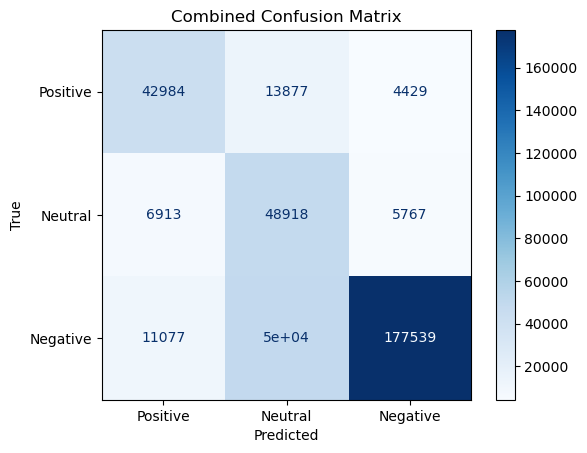

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix')
plt.show()

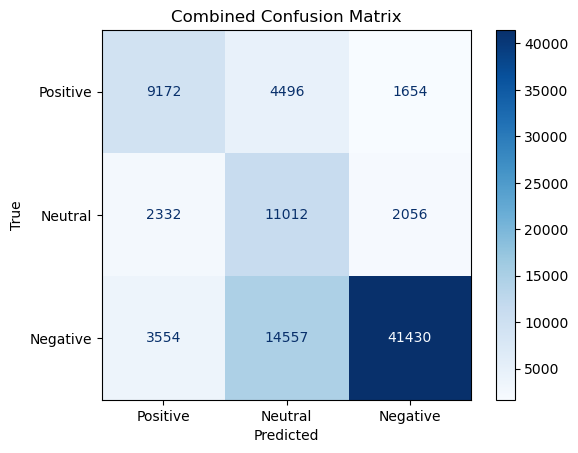

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix')
plt.show()

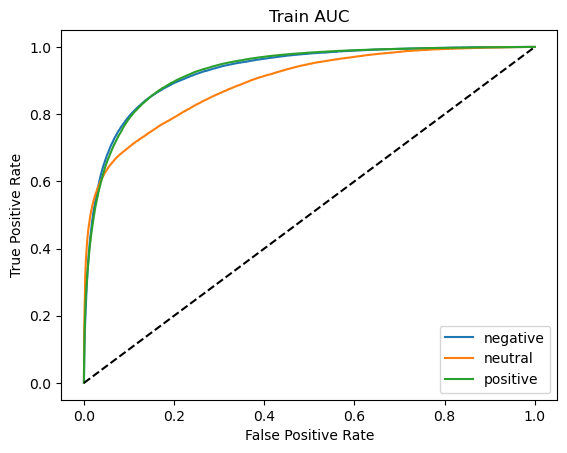

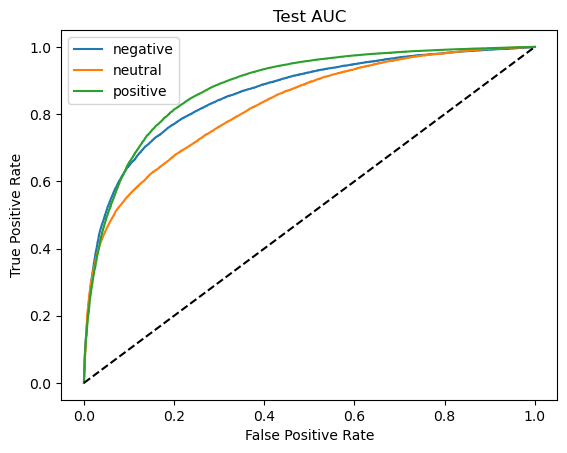

In [29]:
# AUC Plots

def plot_auc(y_true, y_score, title):
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

plot_auc(y_train, train_pred_prob, "Train AUC")
plot_auc(y_test, test_pred_prob, "Test AUC")

In [30]:
# Feature Insights (basic token frequency)
top_features = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:2]


In [40]:
# Summary
print("\nMODEL TRAINING SUMMARY")
print("="*150)
print(f"Train Time: {train_time:.2f} seconds")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Train F1 Score (Positive): {train_f1_positive:.4f}")
print(f"Train F1 Score (Negative): {train_f1_negative:.4f}")
print(f"Test F1 Score (Positive): {test_f1_positive:.4f}")
print(f"Test F1 Score (Negative): {test_f1_negative:.4f}")
print("Top 2 frequent features:", top_features[0][0], ",", top_features[1][0])


MODEL TRAINING SUMMARY
Train Time: 23260.82 seconds
Train Accuracy: 0.7463
Test Accuracy: 0.6826
Train AUC: 0.9165
Test AUC: 0.8573
Train F1 Score (Positive): 0.8337
Train F1 Score (Negative): 0.7031
Test F1 Score (Positive): 0.7915
Test F1 Score (Negative): 0.6038
Top 2 frequent features: freedom , convoy
